<a href="https://colab.research.google.com/github/mine0123/final/blob/master/finalproject_KMW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GitHub에서 불러오기



In [8]:
!git clone https://github.com/mine0123/final.git

fatal: destination path 'final' already exists and is not an empty directory.


# face-mask-detector 디렉토리로 이동

In [9]:
cd final/

/content/final/face-mask-detector-master/final


In [10]:
cd face-mask-detector-master/

/content/final/face-mask-detector-master/final/face-mask-detector-master


# 모델 로드 (Open CV 사용)


1.   사진 속에서 얼굴을 탐지하는 모델
2.   얼굴인식 후 마스크 착용 여부를 확인하는 모델





In [11]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# 사진 속에서 얼굴을 탐지하는 모델 (face_detector)
facenet = cv2.dnn.readNet('face_detector/deploy.prototxt','face_detector/res10_300x300_ssd_iter_140000.caffemodel')
# 얼굴인식 후 마스크 착용 여부를 확인하는 모델 (mask_detector)
model = load_model('mask_detector.model')

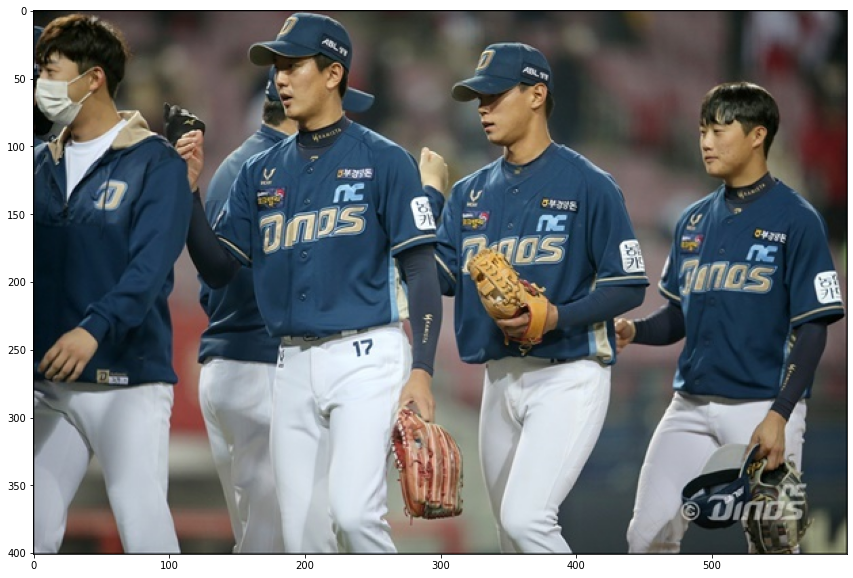

In [26]:
# OpenCV를 사용해서 사진을 matplotlib 으로 화면에 출력
# OpenCV → BGR 순서로 저장 /  matplotlib → RGB 순서로 저장 / 따라서 BGR을 RGB로 바꾸어 주는 작업 필요

img = cv2.imread('/content/final/face-mask-detector-master/examples/example_05.jpg')
h,w = img.shape[:2]
plt.figure(figsize=(16,10))
plt.imshow(img[:,:,::-1]) # BGR -> RGB 변환

# Preprocessing (얼굴 탐지 모델 학습하기)

In [27]:
blob = cv2.dnn.blobFromImage(img, scalefactor = 1.0, size = (300, 300), mean = (104.0, 177.0, 123.0))
# blob을 통해 얼굴 학습 (불러올 이미지, 이미지 크기 조절 유무, 신경망이 예상하는 이미지의 크기, 평균 빼기값)
facenet.setInput(blob) # 얼굴 탐지 모델에 들어가는 input
detections = facenet.forward() # output

#  Detect Faces (얼굴 탐지 모델 이미지 출력)

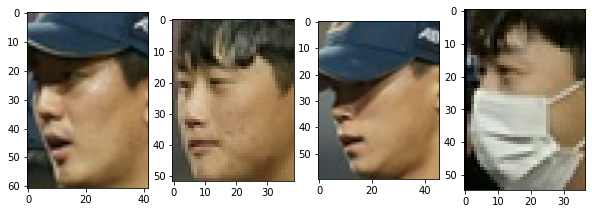

In [28]:
faces = []

# 사진속 얼굴 개수가 여러 개 있을 수 있으니 반복문 사용
for i in range(detections.shape[2]):
  confidence = detections[0,0,i,2] # 4차원 배열에서 사람의 얼굴이라고 인식된 부분들 → 이미지로 출력될 부분

  if confidence < 0.5: # 사람의 얼굴로 인식될 정확도 (50%)
    continue
  else:
     x1 = int(detections[0,0,i,3] * w) # 박스 시작점의 x좌표 상대위치 (왼쪽 맨 위)
     y1 = int(detections[0,0,i,4] * h) # 박스 시작점의 y좌표 상대위치
     x2 = int(detections[0,0,i,5] * w) # 박스 끝점의 x좌표 상대위치 (오른쪽 맨 아래)
     y2 = int(detections[0,0,i,6] * h) # 박스 끝점의 y좌표 상대위치

     face = img[y1:y2, x1:x2]
     faces.append(face)

plt.figure(figsize=(10,5))

for i, face in enumerate(faces):
    plt.subplot(1, len(faces), i+1)
    plt.imshow(face[:, :, ::-1])
    current_face = face[:, :, ::-1]
    cv2.imwrite('face_result/result_{}.jpg'.format(i), cv2.cvtColor(current_face, cv2.COLOR_BGR2RGB))

# detect_mask_image (이미지에서 실행)

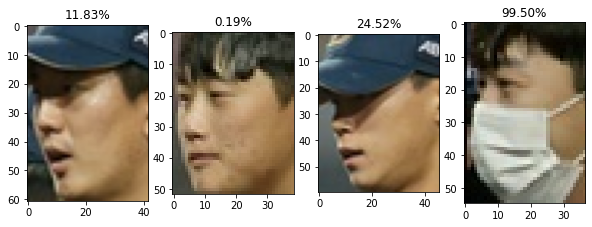

In [29]:
plt.figure(figsize=(10,5))

for i, face in enumerate(faces):
    face_input = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    face_input = cv2.resize(face_input, dsize=(224, 224))
    face_input = preprocess_input(face_input)
    face_input = np.expand_dims(face_input, axis=0)

    (mask, nomask) = model.predict(face_input)[0]

    plt.subplot(1, len(faces), i+1)
    plt.imshow(face[:, :, ::-1])
    plt.title('%.2f%%' % (mask * 100))

# detect_mask_video (동영상에서 실행)

In [30]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

cap = cv2.VideoCapture('examples/02.mp4') # mp4 파일 인식
ret, img = cap.read()

fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
out = cv2.VideoWriter('./output.mp4', fourcc, cap.get(cv2.CAP_PROP_FPS), (img.shape[1], img.shape[0]))

while cap.isOpened():
    ret, img = cap.read()
    if not ret:
        break

    h, w = img.shape[:2]

    blob = cv2.dnn.blobFromImage(img, scalefactor=1., size=(300, 300), mean=(104., 177., 123.))
    facenet.setInput(blob)
    dets = facenet.forward()

    result_img = img.copy()

    for i in range(dets.shape[2]):
        confidence = dets[0, 0, i, 2]
        if confidence < 0.5:
            continue

        x1 = int(dets[0, 0, i, 3] * w)
        y1 = int(dets[0, 0, i, 4] * h)
        x2 = int(dets[0, 0, i, 5] * w)
        y2 = int(dets[0, 0, i, 6] * h)

        face = img[y1:y2, x1:x2]

        face_input = cv2.resize(face, dsize=(224, 224))
        face_input = cv2.cvtColor(face_input, cv2.COLOR_BGR2RGB)
        face_input = preprocess_input(face_input)
        face_input = np.expand_dims(face_input, axis=0)

        mask, nomask = model.predict(face_input).squeeze()

        if mask > nomask:
            color = (0, 255, 0) # Green 마스크 착용
            label = 'Mask %d%%' % (mask * 100)
        else:
            color = (0, 0, 255) # Red 마스크 미착용
            label = 'No Mask %d%%' % (nomask * 100)

        cv2.rectangle(result_img, pt1=(x1, y1), pt2=(x2, y2), thickness=2, color=color, lineType=cv2.LINE_AA)
        cv2.putText(result_img, text=label, org=(x1, y1 - 10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=color, thickness=2, lineType=cv2.LINE_AA)

    out.write(result_img)
    #cv2_imshow(result_img) # colab 환경에서 출력 때문에 계속 Busy 상태라 ignore
    if cv2.waitKey(1) == ord('q'):
        break

out.release()
cap.release()